In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("PredictiveMaintenance") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()
# Check the Spark session
print(spark)

In [3]:
df = spark.read.csv("hdfs://localhost:9000/user/legit/predictive_maintenance/predictive_maintenance_dataset.csv", header=True, inferSchema=True)

# Show the first few rows
df.show(5)


+--------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
|    date|  device|failure|  metric1|metric2|metric3|metric4|metric5|metric6|metric7|metric8|metric9|
+--------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
|1/1/2015|S1F01085|      0|215630672|     55|      0|     52|      6| 407438|      0|      0|      7|
|1/1/2015|S1F0166B|      0| 61370680|      0|      3|      0|      6| 403174|      0|      0|      0|
|1/1/2015|S1F01E6Y|      0|173295968|      0|      0|      0|     12| 237394|      0|      0|      0|
|1/1/2015|S1F01JE0|      0| 79694024|      0|      0|      0|      6| 410186|      0|      0|      0|
|1/1/2015|S1F01R2B|      0|135970480|      0|      0|      0|     15| 313173|      0|      0|      3|
+--------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
only showing top 5 rows



In [4]:
# Convert 'date' column to date type
df = df.withColumn('date', to_date(col('date'), 'MM/dd/yyyy'))

# Extract year and month from 'date' column
df = df.withColumn('year', year(col('date'))).withColumn('month', month(col('date')))

In [5]:
# Assemble features
assembler = VectorAssembler(inputCols=[f'metric{i}' for i in range(1, 10)], outputCol='features')
df = assembler.transform(df)

In [6]:
# Scale features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [7]:
# Split data into training and test sets
(train_df, test_df) = df.randomSplit([0.7, 0.3], seed=1234)

In [8]:
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol='scaled_features', labelCol='failure')

In [9]:
# Fit the model on the training data
lr_model = lr.fit(train_df)

In [13]:
# Make predictions on the test data
predictions = lr_model.transform(test_df)

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='failure')

In [17]:
import pandas as pd
# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Test Area Under ROC: {accuracy}")

Test Area Under ROC: 0.8230141245209209


In [18]:
# Print detailed classification metrics
pdf = predictions.select('failure', 'prediction').toPandas()
conf_matrix = pd.crosstab(pdf['failure'], pdf['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
Predicted    0.0  1.0
Actual               
0          37310    1
1             25    0


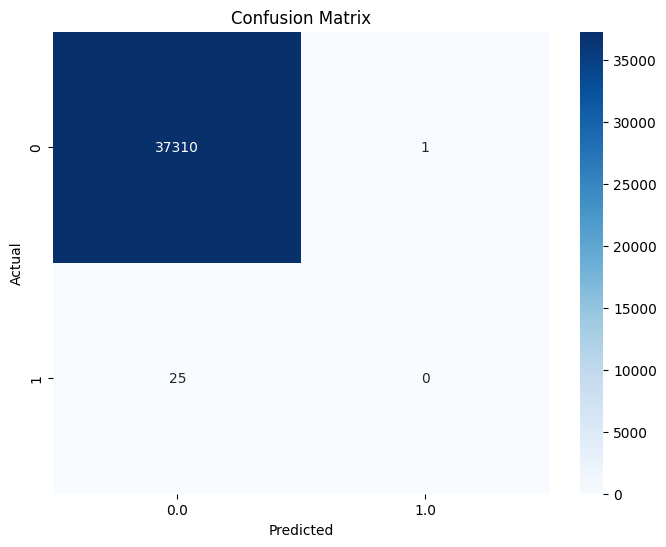

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.linalg import DenseVector

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import roc_curve

# Retrieve ROC curve data
y_true = pdf['failure'].values
y_scores = pdf['prediction'].values
fpr, tpr, _ = roc_curve(y_true, y_scores)

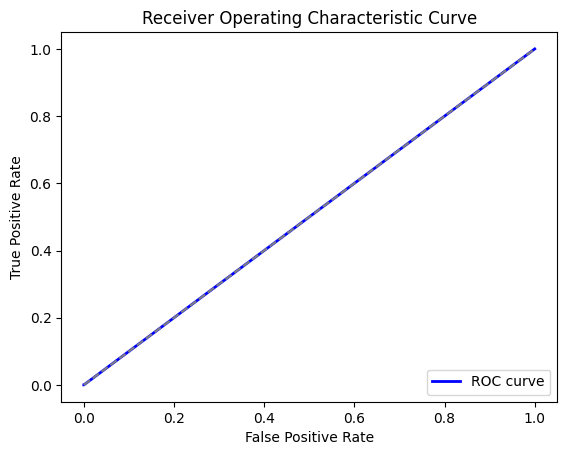

In [24]:
# Generate ROC plot
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend(loc='lower right')
plt.show()